In [147]:
import sys
import math
import itertools
import random
import time
from functools import lru_cache
from collections import deque, defaultdict
import matplotlib.pyplot as plt
import heapq

In [148]:
def floydWarshall(n, graph):
    D = [[math.inf]*n for _ in range(n)]
    #dijagonale se popune nulom
    for i in range(n):
        D[i][i] = 0

    #trazimo minimum izmedju svaka dva povezana cvora
    for i, j, w in graph:
        D[i][j] = min(D[i][j], w)
        D[j][i] = min(D[j][i], w)

    #trazimo najkraci put izmedju svaka dva cvora kao min trenutnog rezultata i puta preko nekog treceg cvora
    for k in range(n):
        for i in range(n):
            for j in range(n):
                if D[i][j] > D[i][k] + D[k][j]:
                    D[i][j] = D[i][k] + D[k][j]

    return D

In [149]:
def oddDegVertices(n, edges):
    deg = [0]*n #pravi praznu matricu
    for u, v, _ in edges:
        #povecava stepen za 1, ako je neparan na kraju cvor ce biti u listi
        deg[u] += 1
        deg[v] += 1
    return [i for i in range(n) if deg[i] % 2 == 1] #vrati one cvorove koji imaju neparan stepen(neparan broj suseda, tj izlaznih grana)

In [150]:
def minCost(odd_vertices, D):
    """
    Bitmask
    Minimalan trosak da se cvorovi sa neparnim stepenom upare
    odd_vertices - lista cvorova sa neparnim stepenom
    D - matrica gde je D[i][j] tezina najkraceg puta izmedju i i j
    """
    if not odd_vertices:
        return 0

    #uvek ce biti paran broj cvorova pa nema potrebe za proverom(Lema)
    n = len(odd_vertices)
    memo = {}
    
    #@lru_cache(maxsize=None)
    def dp(mask):
        if mask == (1 << n) - 1: #ako su svi cvorovi upareni
            return 0
        if mask in memo:
            return memo[mask]
        #nadji prvi neupareni
        for i in range(n):
            if not (mask & (1 << i)):
                break
    
        best = math.inf
        for j in range(i+1, n):
            if not (mask & (1 << j)):
                cost = D[odd_vertices[i]][odd_vertices[j]] + dp(mask | (1 << i) | (1 << j)) #maska pokazuje da su upareni i i j cvorovi
                best = min(best, cost)
        memo[mask] = best
        return best
    return dp(0)

In [151]:
def minCost_with_pairs(odd_vertices, D):
    """
    Alternativa minCost, vraca i parove
    Bitmask
    Minimalan trosak da se cvorovi sa neparnim stepenom upare
    odd_vertices - lista cvorova sa neparnim stepenom
    D - matrica gde je D[i][j] tezina najkraceg puta izmedju i i j
    """
    if not odd_vertices:
        return 0, []

    n = len(odd_vertices)
    memo = {}
    choice = {}

    FULL = (1 << n) - 1

    def dp(mask):
        if mask == FULL:
            return 0
        if mask in memo:
            return memo[mask]
        #pronadji prvi neparirani
        i = 0
        while (mask & (1 << i)):
            i += 1

        best = math.inf
        best_pair = None
        for j in range(i+1, n):
            if not (mask & (1 << j)):
                new_mask = mask | (1 << i) | (1 << j)
                dij = D[odd_vertices[i]][odd_vertices[j]]
                if dij == math.inf:
                    continue  #neparovi koje nije moguce povezati preskacemo
                cost = dij + dp(new_mask)
                if cost < best:
                    best = cost
                    best_pair = j
        memo[mask] = best
        choice[mask] = (i, best_pair)
        return best

    total_cost = dp(0)
    if total_cost == math.inf:
        return math.inf, []

    #rekonstrukcija parova
    pairs = []
    mask = 0
    while mask != FULL:
        i, j = choice[mask]
        pairs.append((odd_vertices[i], odd_vertices[j]))
        mask = mask | (1 << i) | (1 << j)

    return total_cost, pairs


In [152]:
def build_adj(n, graph):
    """
    graph: lista (u, v, w) koja predstavlja neusmerene grane
    vraća adjacency listu: adj[u] = [(v,w), ...]
    """
    adj = [[] for _ in range(n)]
    for u, v, w in graph:
        adj[u].append((v, w))
        adj[v].append((u, w))
    return adj


In [153]:
def dijkstra_from_source(n, adj, src):
    dist = [math.inf] * n
    prev = [-1] * n
    dist[src] = 0
    pq = [(0, src)]
    while pq:
        d, u = heapq.heappop(pq)
        if d > dist[u]:
            continue
        for v, w in adj[u]:
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd, v))
    return dist, prev

def all_pairs_dijkstra(n, graph, sources=None):
    """
    Ako sources==None -> izračunaj za sve čvorove (skupo za velike n)
    Ako sources je lista -> izračunaj samo za te izvore
    Vraća (D, prevs) gde je D matrica udaljenosti, prevs dict src -> prev-list
    """
    adj = build_adj(n, graph)
    D = [[math.inf]*n for _ in range(n)]
    prevs = {}
    if sources is None:
        sources = list(range(n))
    for s in sources:
        dist, prev = dijkstra_from_source(n, adj, s)
        D[s] = dist
        prevs[s] = prev
    return D, prevs


In [157]:
"""
Cycle-Trade heuristika za kineskog postara
1. Raspodeli grane u k ciklusa za svakog od k postara
2. Trade: prebaci deo grana iz jednog ciklusa u drugi ili zameni grane izmedju 2 postara
3. Tabu list: cuva poteze koji su nedavno uradjeni
4. Cilj je minimizovati max(len_cycle)
5. Zaustavlja se kada prodje odredjen broj iteracija bez poboljsanja ili istekne zadato vreme
"""

'\nCycle-Trade heuristika za kineskog postara\n1. Raspodeli grane u k ciklusa za svakog od k postara\n2. Trade: prebaci deo grana iz jednog ciklusa u drugi ili zameni grane izmedju 2 postara\n3. Tabu list: cuva poteze koji su nedavno uradjeni\n4. Cilj je minimizovati max(len_cycle)\n5. Zaustavlja se kada prodje odredjen broj iteracija bez poboljsanja ili istekne zadato vreme\n'

In [158]:
def generateConnectedGraph(n, extra_edges=20, a=1, b=10):
    graph = []

    #kreira lanac koji povezuje sve cvorove
    for i in range(n-1):
        w = random.randint(a,b)
        graph.append((i, i+1, w))

    #spoja prvi i poslednji cvor i formira ciklus
    graph.append((0, n-1, random.randint(a,b)))

    #dodaje nasumicne grane bez duplikata
    added_edges = set((min(u,v), max(u,v)) for u,v,_ in graph)
    attempts = 0
    while len(added_edges) < n-1 + 1 + extra_edges and attempts < extra_edges*5:
        u, v = random.sample(range(n), 2)
        if (min(u,v), max(u,v)) not in added_edges:
            w = random.randint(a,b)
            graph.append((u, v, w))
            added_edges.add((min(u,v), max(u,v)))
        attempts += 1

    return graph


In [159]:
def initialSolution(m, k):
    #nasumicno dodeli svaku granu nekom postaru
    return [random.randint(0, k-1) for _ in range(m)]

In [160]:
def lengthCycle(edges, n, D, start):
    #racuna duzinu ciklusa
    #dodao sam penalty jer moze da se desi da podgraf ima neparan broj cvorova neparnog stepena
    #da ne bih dodavao start 2 puta penalty=10**6
    if not edges:
        return 0
    odd = oddDegVertices(n, edges)
    #ako start nije deo ciklusa moramo ga dodati
    if start not in odd:
        odd.append(start)

    if len(odd) % 2 == 1:
        odd.append(start)
    
    # koristimo minCost_with_pairs (vraca trošak i listu parova)
    #alternativa je minCost
    cost_pairs_cost, pairs = minCost_with_pairs(odd, D)
    # ako nema rešenja, vrati veliki penalty
    if cost_pairs_cost == math.inf:
        penalty = 10**9
        return sum(w for _,_,w in edges) + penalty

    return sum(w for _,_,w in edges) + cost_pairs_cost

In [170]:
def tabuSolution(solution, start, k, n, graph, D):
    #trazi max duzinu ciklusa
    cycles = [[] for _ in range(k)]
    for edge_idx, p in enumerate(solution):
        cycles[p].append(graph[edge_idx])
    lengths = [lengthCycle(cycle, n, D, start) if cycle else 0 for cycle in cycles]
    
    return max(lengths), lengths

In [162]:
def tabuSolutionIncremental(solution, start, n, graph, D, lengths, move):
    #update samo dva postara na koja smo primenili move
    edge_idx, p1, p2 = move
    new_lengths = lengths[:]

    # stari i novi ciklus
    old_cycle = [graph[i] for i, p in enumerate(solution) if p == p1 and i != edge_idx]
    new_cycle = [graph[i] for i, p in enumerate(solution) if p == p2] + [graph[edge_idx]]

    new_lengths[p1] = lengthCycle(old_cycle, n, D, start) if old_cycle else 0
    new_lengths[p2] = lengthCycle(new_cycle, n, D, start)

    return max(new_lengths), new_lengths

In [163]:
def tabuNeighbors(solution, k, max_neighbors = None):
    if solution is None:
        print("ERROR: solution je None u tabuNeighbors!")
    #generisi susede - cycle trades, opciono moze da se ogranici broj
    m = len(solution)
    all_moves = []
    #za svaku granu posmatramo kom postaru je dodeljena
    for i in range(m):
        current_postman = solution[i]
        for p in range(k):
            if p != current_postman:
                all_moves.append((i, current_postman, p))

    if max_neighbors is not None and len(all_moves) > max_neighbors:
        all_moves = random.sample(all_moves, max_neighbors)

    return all_moves

In [164]:
def cycleTrade(start, k, n, graph, max_iter=120, tabu_capacity=15, max_neighbors=50):
    #cycle-trade tabu search
    #D = floydWarshall(n, graph) #matrica najkracih puteva
    #dijkstra malo efikasnija od floydWarshall-a
    D, prevs = all_pairs_dijkstra(n, graph)
    
    m = len(graph) #broj grana

    current = initialSolution(m, k) #pocetno resenje
    if current is None:
            print(f"[DEBUG] Iteracija {i}: Nema kandidata, current={current}")
    
    current_value, current_lengths = tabuSolution(current, start, k, n, graph, D)

    best = current[:]
    best_value = current_value
    history = [best_value]

    #tabu list FIFO
    tabu = deque(maxlen=tabu_capacity)

    #merenje vremena izvrsavanja
    start_time = time.time()
    iter_times = []
    
    for i in range(max_iter):
        iter_start = time.time()
        
        candidate = None
        candidate_value = math.inf
        candidate_move = None
        candidate_lengths = None

        #generisi susede
        for move in tabuNeighbors(current, k, max_neighbors=max_neighbors):
            #ako smo vec uradili move preskacemo ga
            if move in tabu:
                continue

            value, new_lengths = tabuSolutionIncremental(current, start, n, graph, D, current_lengths, move)
            if value == math.inf:
                    continue
            if value < candidate_value:
                candidate = current[:]
                candidate[move[0]] = move[2] #primeni move
                candidate_value = value
                candidate_move = move
                candidate_lengths = new_lengths

        #ako su svi susedi u tabu, uzmi najbolji tabu
        if candidate is None:
            for move in tabuNeighbors(current, k, max_neighbors=max_neighbors):
                value, new_lengths = tabuSolutionIncremental(current, start, n, graph, D, current_lengths, move)
                if value == math.inf:
                    continue
                if value < candidate_value:
                    candidate = current[:]
                    candidate[move[0]] = move[2] #primeni move
                    candidate_value = value
                    candidate_move = move
                    candidate_lengths = new_lengths 

        
        if candidate is None:
            print(f"[DEBUG] Iteracija {i}: Nema kandidata, current={current}")
            break
        
        
        #update
        current = candidate
        current_value = candidate_value
        current_lengths = candidate_lengths
        tabu.append(candidate_move)

        if current_value < best_value:
            best = current[:]
            best_value = current_value

        history.append(current_value)

        iter_time = time.time() - iter_start
        iter_times.append(iter_time)

    total_time = time.time() - start_time
    
    return best, best_value, history, iter_times, total_time

Graph: [(0, 1, 1), (1, 2, 9), (2, 3, 8), (3, 4, 3), (4, 5, 10), (5, 6, 7), (6, 7, 5), (7, 8, 10), (8, 9, 5), (9, 10, 5), (10, 11, 9), (11, 12, 9), (12, 13, 4), (13, 14, 1), (14, 15, 5), (15, 16, 2), (16, 17, 7), (17, 18, 9), (18, 19, 1), (19, 20, 1), (20, 21, 4), (21, 22, 9), (22, 23, 3), (23, 24, 1), (24, 25, 6), (25, 26, 9), (26, 27, 9), (27, 28, 4), (28, 29, 9), (29, 30, 7), (30, 31, 4), (31, 32, 8), (32, 33, 2), (33, 34, 2), (34, 35, 1), (35, 36, 3), (36, 37, 10), (37, 38, 10), (38, 39, 5), (39, 40, 4), (40, 41, 7), (41, 42, 5), (42, 43, 6), (43, 44, 6), (44, 45, 4), (45, 46, 5), (46, 47, 6), (47, 48, 4), (48, 49, 2), (0, 49, 4), (41, 32, 6), (17, 15, 8), (36, 26, 1), (30, 45, 7), (49, 45, 6), (3, 33, 6), (0, 35, 2), (33, 23, 9), (13, 28, 7), (20, 35, 9), (47, 31, 5), (41, 37, 8), (42, 5, 5), (41, 1, 3), (3, 19, 5)]
Best solution cycle-trade: [7, 0, 5, 1, 5, 2, 8, 5, 1, 1, 3, 0, 3, 2, 4, 4, 7, 9, 9, 4, 3, 4, 2, 7, 1, 8, 3, 9, 3, 1, 8, 7, 4, 2, 2, 5, 6, 7, 8, 3, 4, 2, 8, 6, 9, 8, 6,

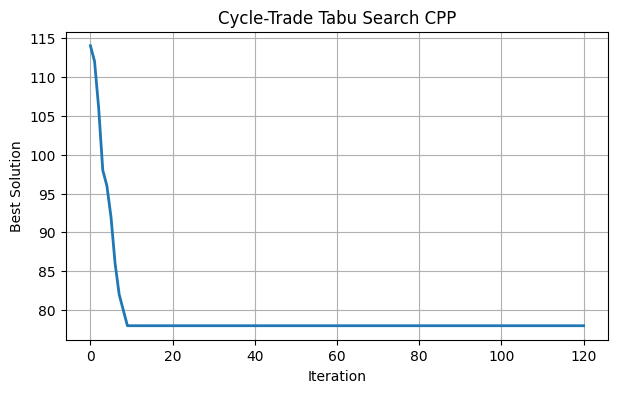

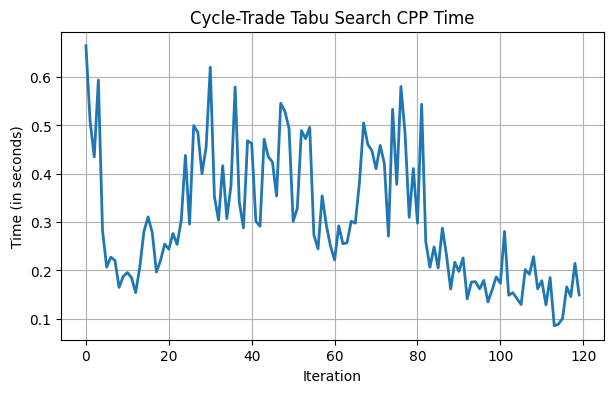

In [171]:
if __name__ == "__main__":
    n = 50
    graph = generateConnectedGraph(n, extra_edges = 15)
    start = 0
    k = 10

    """
    D = floydWarshall(n, graph)
    for i in range(n):
        for j in range(n):
            if D[i][j] == math.inf:
                print(f"Ne postoji put između {i} i {j}")
    """
        
    print("Graph:", graph)
    #bestbf = bruteForceCPP(start, k, n, graph)
    best, best_solution, history, iter_times, total_time = cycleTrade(start, k, n, graph)

    #print("Best solution brute force:", bestbf)
    print("Best solution cycle-trade:", best)
    print("Best result:", best_solution)
    print("Time:", round(total_time, 4), "s")

    plt.figure(figsize=(7,4))             
    plt.plot(history, linewidth=2)
    #plt.axhline(bestbf, color='r')
    plt.xlabel("Iteration")               
    plt.ylabel("Best Solution")        
    plt.title("Cycle-Trade Tabu Search CPP")  
    plt.grid(True)                        
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(iter_times, linewidth=2)
    plt.xlabel("Iteration")
    plt.ylabel("Time (in seconds)")
    plt.title("Cycle-Trade Tabu Search CPP Time")
    plt.grid(True)
    plt.show()